In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np 
import math
%matplotlib inline

In [2]:
#Reading meta-data files
unis = pd.read_csv('../data/IPEDS/hd2020.csv',encoding='cp1252')


## Preprocessing meta-data files
### Updating names to match in rankings  
unis.loc[unis['IALIAS']=='Virginia Tech', 'INSTNM'] = 'Virginia Tech'
unis.loc[unis['INSTNM']=='University of Illinois Urbana-Champaign', 'INSTNM'] = 'University of Illinois at Urbana-Champaign'
unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM'] = "St. John's College - MD"
unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM'] = "St. John's College - NM"
unis.loc[unis['INSTNM']=="William & Mary", 'INSTNM'] = "College of William and Mary"
unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM'] = "Brigham Young University-Provo"
unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"

### Labeling 

# Making sure all institutes are captured in ranking


In [3]:
unis
unis['LONGITUD']

,UNITID,INSTNM,IALIAS,ADDR,CITY,STABBR,ZIP,FIPS,OBEREG,CHFNM,...,CBSATYPE,CSA,NECTA,COUNTYCD,COUNTYNM,CNGDSTCD,LONGITUD,LATITUDE,DFRCGID,DFRCUSCG
0,100654,Alabama A & M University,AAMU,4900 Meridian Street,Normal,AL,35762,1,5,"Dr. Andrew Hugine, Jr.",...,1,290,-2,1089,Madison County,105,-86.568502,34.783368,109,1
1,100663,University of Alabama at Birmingham,,Administration Bldg Suite 1070,Birmingham,AL,35294-0110,1,5,Ray L. Watts,...,1,142,-2,1073,Jefferson County,107,-86.799345,33.505697,95,1
2,100690,Amridge University,Southern Christian University Regions University,1200 Taylor Rd,Montgomery,AL,36117-3553,1,5,Michael C.Turner,...,1,388,-2,1101,Montgomery County,102,-86.174010,32.362609,126,2
3,100706,University of Alabama in Huntsville,UAH University of Alabama Huntsville,301 Sparkman Dr,Huntsville,AL,35899,1,5,Darren Dawson,...,1,290,-2,1089,Madison County,105,-86.640449,34.724557,99,2
4,100724,Alabama State University,,915 S Jackson Street,Montgomery,AL,36104-0271,1,5,Quinton T. Ross,...,1,388,-2,1101,Montgomery County,107,-86.295677,32.364317,118,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6435,496335,Coastline Beauty College - Hemet,,2627 West Florida Avenue Suite 100,Hemet,CA,92545-3661,6,8,,...,1,348,-2,6065,Riverside County,636,-116.999900,33.746000,-2,-2
6436,496371,Elite Welding Academy,South Point,1910 County Road One,South Point,OH,45680-8849,39,3,Bob Reeves,...,1,170,-2,39087,Lawrence County,3906,-82.594354,38.447233,217,2
6437,496380,Medspa Academies - NIMA National Institute of ...,,3993 Howard Hughes Parkway Suite 150,Las Vegas,NV,89169-6745,32,8,,...,1,332,-2,32003,Clark County,3201,-115.158153,36.117261,-2,-2
6438,496414,TechSherpas 365,,10213 Wilsky Blvd,Tampa,FL,33625,12,5,Della Wyler,...,1,-2,-2,12057,Hillsborough County,1214,-82.565846,28.042450,-1,-1


In [14]:
data.head()

,UNITID,CIPCODE,MAJORNUM,AWLEVEL,XCTOTALT,CTOTALT,XCTOTALM,CTOTALM,XCTOTALW,CTOTALW,...,XCUNKNM,CUNKNM,XCUNKNW,CUNKNW,XCNRALT,CNRALT,XCNRALM,CNRALM,XCNRALW,CNRALW
0,100654,1.0999,1,5,R,3,Z,0,R,3,...,Z,0,R,1,Z,0,Z,0,Z,0
1,100654,1.1001,1,5,R,7,R,2,R,5,...,Z,0,Z,0,Z,0,Z,0,Z,0
2,100654,1.1001,1,7,R,4,R,0,R,4,...,Z,0,Z,0,R,2,R,0,R,2
3,100654,1.1001,1,17,R,2,R,2,R,0,...,Z,0,Z,0,R,1,R,1,R,0
4,100654,1.9999,1,5,R,6,R,4,R,2,...,R,1,R,0,Z,0,Z,0,Z,0


In [4]:
data = pd.read_csv('../data/IPEDS/c2020_a.csv')
boolmap = data['CIPCODE'].apply(lambda x: x >= 11 and x < 12)
cs = data[boolmap]
sums = cs.groupby('UNITID').sum()
sums = sums.reset_index()
sums.head()

,UNITID,CIPCODE,MAJORNUM,AWLEVEL,CTOTALT,CTOTALM,CTOTALW,CAIANT,CAIANM,CAIANW,...,CWHITW,C2MORT,C2MORM,C2MORW,CUNKNT,CUNKNM,CUNKNW,CNRALT,CNRALM,CNRALW
0,100654,22.0202,2,12,29,16,13,0,0,0,...,0,0,0,0,4,2,2,3,2,1
1,100663,66.2710,6,49,114,89,25,0,0,0,...,5,2,2,0,1,1,0,28,19,9
2,100706,77.3214,8,63,177,135,42,2,2,0,...,30,1,0,1,6,6,0,25,22,3
3,100724,33.2201,3,17,43,28,15,0,0,0,...,1,0,0,0,0,0,0,3,3,0
4,100751,55.1407,6,39,119,102,17,0,0,0,...,11,6,5,1,0,0,0,15,13,2


In [7]:
merged.sort_values('women', ascending=False)[:50]

,unitid,name,women,native,black,hispanic
827,163204,University of Maryland Global Campus,1048,7,1111,387
1308,193900,New York University,800,2,49,89
2598,484613,University of Phoenix-Arizona,711,20,486,344
2131,236948,University of Washington-Seattle Campus,629,2,19,45
2665,495767,The Pennsylvania State University,616,3,105,158
1651,211440,Carnegie Mellon University,596,0,15,26
733,156365,Campbellsville University,573,0,0,0
1980,228787,The University of Texas at Dallas,544,1,34,91
944,170976,University of Michigan-Ann Arbor,543,1,28,56
466,139755,Georgia Institute of Technology-Main Campus,537,1,72,124


In [6]:
# CTOTALW = total women
# CAIANT = total native
# CBKAAT = total black
# CHISPT = hispanic total
columns = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT']
filtered = sums[columns]
#filtered.columns = ['unitid', 'women', 'native', 'black', 'hispanic']
merged = pd.merge(filtered, unis[['UNITID', 'INSTNM']], on = 'UNITID', how='left')
#merged[['un', 'INSTNM', 'women', 'native', 'black', 'hi]
merged = merged[['UNITID', 'INSTNM', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT']]
merged.columns = ['unitid', 'name', 'women', 'native', 'black', 'hispanic']
merged


,unitid,name,women,native,black,hispanic
0,100654,Alabama A & M University,13,0,21,0
1,100663,University of Alabama at Birmingham,25,0,10,6
2,100706,University of Alabama in Huntsville,42,2,7,3
3,100724,Alabama State University,15,0,39,0
4,100751,The University of Alabama,17,0,6,3
...,...,...,...,...,...,...
2663,494287,EDP University of Puerto Rico-Manati,0,0,0,4
2664,495013,Western Maricopa Education Center,1,0,0,3
2665,495767,The Pennsylvania State University,616,3,105,158
2666,496186,California Institute of Arts & Technology-Nati...,1,0,1,1


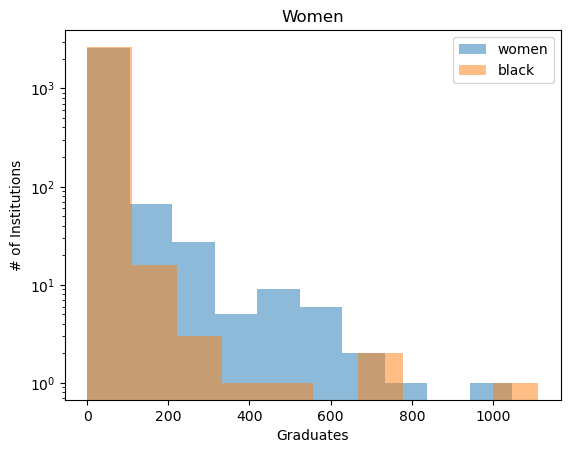

In [8]:
plt.hist(merged['women'], label = 'women', alpha = 0.5)
plt.yscale('log')
plt.title('Women')
plt.xlabel('Graduates')
plt.ylabel('# of Institutions')
boolmap_women = merged['women']==merged['women'].max()
women = merged[boolmap_women]
women['name']
plt.hist(merged['black'], label = 'black', alpha = 0.5)
plt.legend()



Text(0, 0.5, 'black')

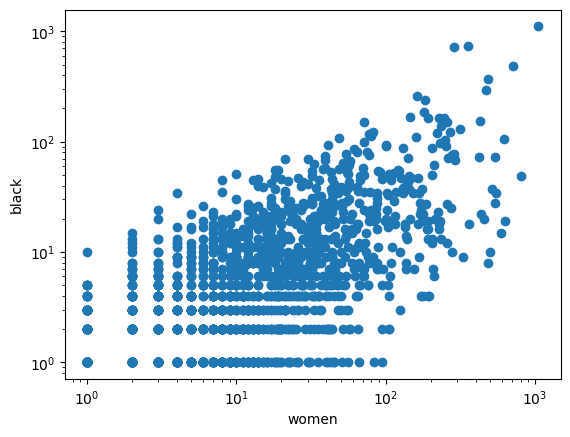

In [17]:
# now we make the scatter plot
# women and black

plt.scatter(merged['women'], merged['black'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('women')
plt.ylabel('black')

Text(0, 0.5, 'hispanic')

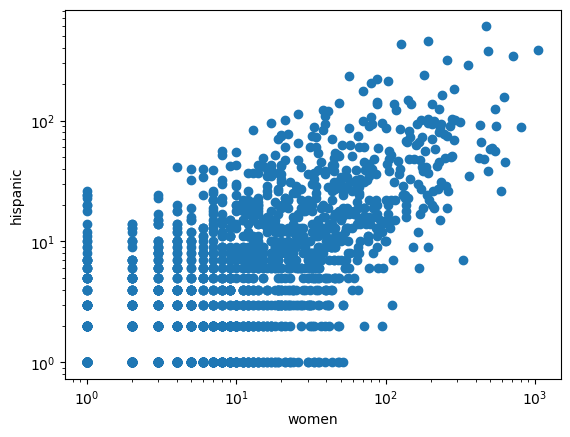

In [18]:
# women and hispanic

plt.scatter(merged['women'], merged['hispanic'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('women')
plt.ylabel('hispanic')

Text(0, 0.5, 'native')

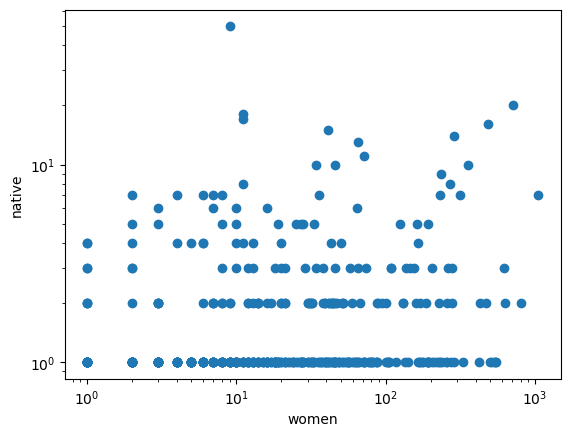

In [15]:
# women and native

plt.scatter(merged['women'], merged['native'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('women')
plt.ylabel('native')

Text(0, 0.5, 'hispanic')

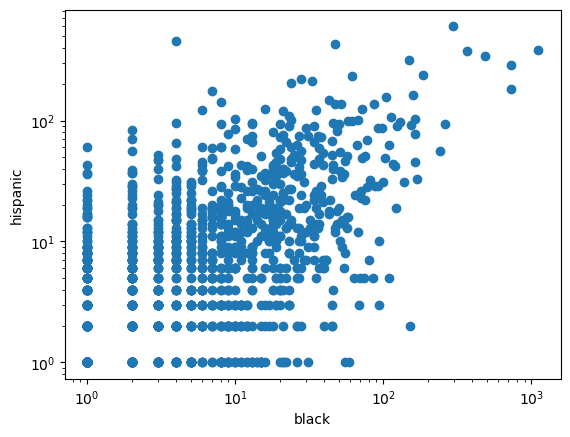

In [19]:
# black and hispanic

plt.scatter(merged['black'], merged['hispanic'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('black')
plt.ylabel('hispanic')

Text(0, 0.5, 'native')

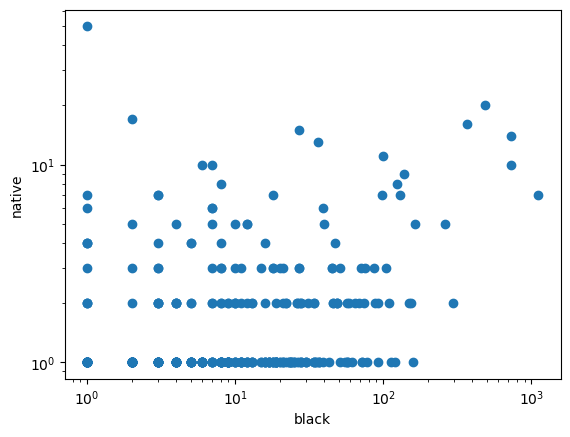

In [20]:
# black and native

plt.scatter(merged['black'], merged['native'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('black')
plt.ylabel('native')

Text(0, 0.5, 'hispanic')

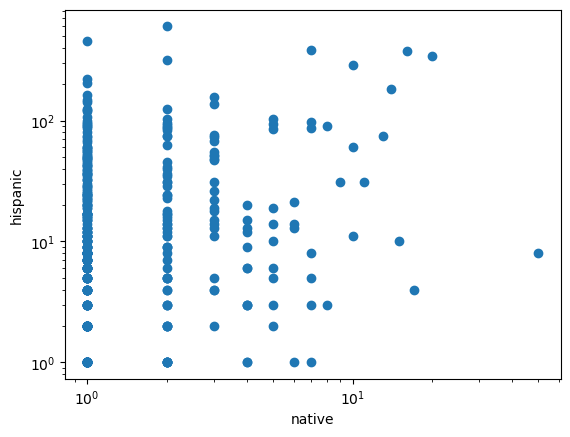

In [21]:
# native and hispanic

plt.scatter(merged['native'], merged['hispanic'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('native')
plt.ylabel('hispanic')

In [23]:
position = pd.merge(merged, unis[['UNITID', 'LONGITUD', 'LATITUDE']], left_on='unitid', right_on='UNITID', how='left')


,unitid,name,women,native,black,hispanic,UNITID,LONGITUD,LATITUDE
0,100654,Alabama A & M University,13,0,21,0,100654,-86.568502,34.783368
1,100663,University of Alabama at Birmingham,25,0,10,6,100663,-86.799345,33.505697
2,100706,University of Alabama in Huntsville,42,2,7,3,100706,-86.640449,34.724557
3,100724,Alabama State University,15,0,39,0,100724,-86.295677,32.364317
4,100751,The University of Alabama,17,0,6,3,100751,-87.545978,33.211875
...,...,...,...,...,...,...,...,...,...
2663,494287,EDP University of Puerto Rico-Manati,0,0,0,4,494287,-66.490949,18.429431
2664,495013,Western Maricopa Education Center,1,0,0,3,495013,-112.292829,33.535973
2665,495767,The Pennsylvania State University,616,3,105,158,495767,-77.862848,40.796500
2666,496186,California Institute of Arts & Technology-Nati...,1,0,1,1,496186,-117.106076,32.661577


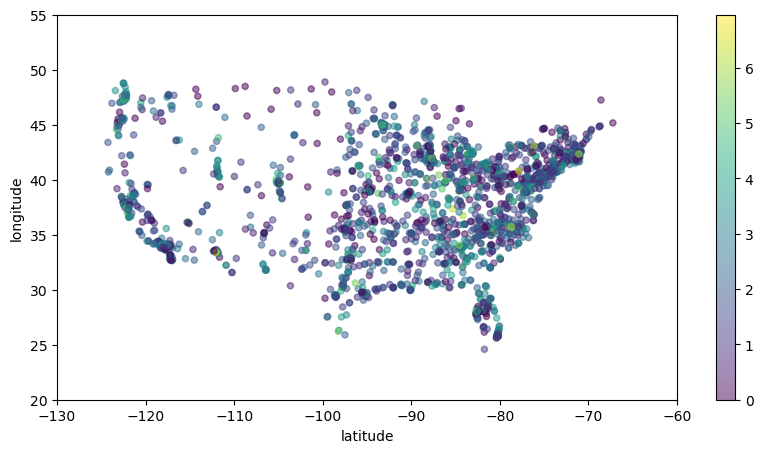

In [48]:
#women
from math import log
plt.figure(figsize = (10, 5))
womenBool = position['women'].apply(lambda x: x > 0)
womenPosition = position[womenBool]
plt.scatter(womenPosition['LONGITUD'], womenPosition['LATITUDE'], c=womenPosition['women'].apply(log), s=20, alpha = 0.5)
plt.ylabel('longitude')
plt.xlabel('latitude')
plt.xlim(-130, -60)
plt.ylim(20, 55)
plt.colorbar()


In [55]:
blackPosition.sort_values('black', ascending=False)[:20]

,unitid,name,women,native,black,hispanic,UNITID,LONGITUD,LATITUDE
827,163204,University of Maryland Global Campus,1048,7,1111,387,163204,-76.847584,38.912706
2554,480037,MyComputerCareer.edu-Raleigh,357,10,735,286,480037,-78.727186,35.767841
2485,451477,MyComputerCareer.edu-Columbus,286,14,727,184,451477,-82.941874,40.147019
2598,484613,University of Phoenix-Arizona,711,20,486,344,484613,-112.012761,33.411280
2402,433387,Western Governors University,485,16,369,377,433387,-111.869752,40.684810
1906,224615,Dallas College,467,2,294,602,224615,-96.794036,32.766319
2276,248934,ECPI University,162,5,260,93,248934,-76.178773,36.842526
475,140012,Gwinnett Technical College,182,0,240,56,140012,-84.066224,33.962763
363,132709,Broward College,180,0,187,239,132709,-80.141830,26.119422
838,164076,Towson University,146,0,168,33,164076,-76.611164,39.393622


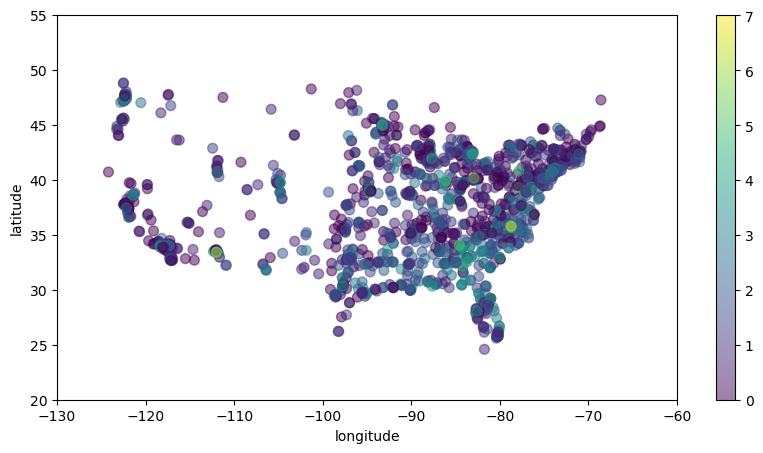

In [51]:
#black

blackBool = position['black'].apply(lambda x: x > 0)
blackPosition = position[blackBool]
plt.figure(figsize = (10, 5))
plt.scatter(blackPosition['LONGITUD'], blackPosition['LATITUDE'], c = blackPosition['black'].apply(log), s = 50, alpha = 0.5)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xlim(-130, -60)
plt.ylim(20, 55)
plt.colorbar()

Text(0.5, 0, 'latitude')

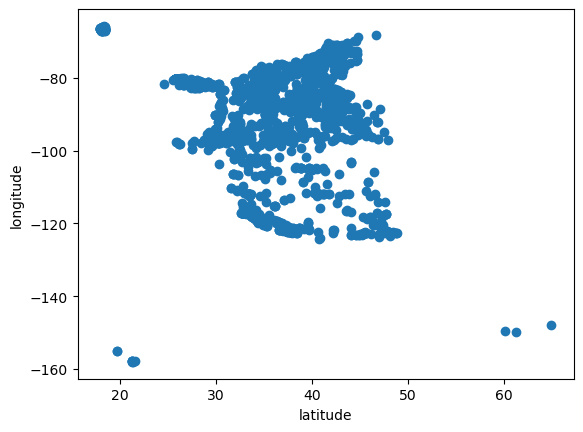

In [30]:
#hispanic

hispanicBool = position['hispanic'].apply(lambda x: x > 0)
hispanicPosition = position[hispanicBool]
plt.scatter(hispanicPosition['LATITUDE'], hispanicPosition['LONGITUD'], norm='linear')
plt.ylabel('longitude')
plt.xlabel('latitude')

Text(0.5, 0, 'latitude')

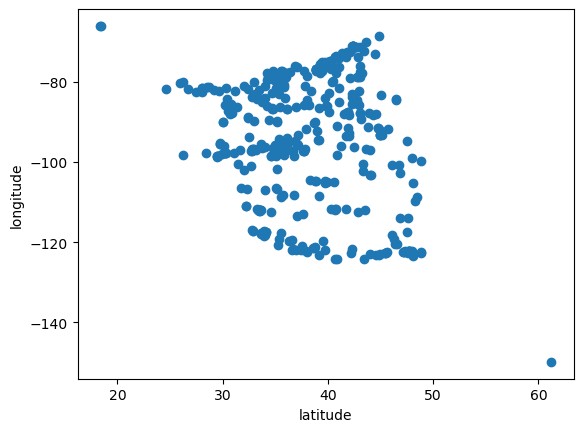

In [31]:
#native

nativeBool = position['native'].apply(lambda x: x > 0)
nativePosition = position[nativeBool]
plt.scatter(nativePosition['LATITUDE'], nativePosition['LONGITUD'], norm='linear')
plt.ylabel('longitude')
plt.xlabel('latitude')